# Task 2 - Perturb ALS genes and Embed

## Imports

In [1]:
import scanpy as sc
import numpy as np
from helical.models.geneformer import Geneformer, GeneformerConfig

from collections.abc import Sequence
from typing import Literal
from anndata import AnnData

  from .autonotebook import tqdm as notebook_tqdm

INFO:datasets:PyTorch version 2.6.0 available.


In [2]:
sc.set_figure_params(dpi=150)

## Functions

In [3]:
# From Task 1
def perturb_genes(
    adata: AnnData,
    target: tuple[str, Sequence[str]],
    factor: tuple[float, Sequence[float]],
    copy: bool = False,
) -> AnnData | None:
    """Perturb selected genes.

    Change the expression of provided genes by a factor and round back to integers.
    Expects raw count data.

    Parameters
    ----------
    adata
        The annotated data matrix.
    target
        Which gene(s) to perturb.
    factor
        Factor for simulated perturbation per provided gene. Must be a positive number.
    copy
        Whether to copy `adata` or modify it inplace.

    Returns
    -------
    Returns `None` if `copy=False`, else returns an `AnnData` object.

    """
    # Sanity checks on inputs
    if isinstance(target, str):
        target = [target]
    if isinstance(factor, float):
        factor = [factor]
        
    if len(target) != len(factor):
        msg = (
            f"the number of provided targets must match the number of provided factors, but {len(target)} and {len(factor)} values were passed, respectively"
        )
        raise ValueError(msg)

    missing_genes = [t for t in target if t not in adata.var_names]
    if missing_genes:
        msg = (
            f"the following provided targets were not found in the index of the provided anndata object: {missing_genes!r}. Example names are {adata.var_names[:3].tolist()}"
        )
        raise ValueError(msg)

    if [f for f in factor if f < 0.]:
        msg = (
            f"some provided factors were smaller than 0. Please only provide positive numbers."
        )
        raise ValueError(msg)

    if len(target) != len(set(target)):
        msg = (
            f"target contains duplicate values."
        )
        raise ValueError(msg)

    # Create copy of adata if requested
    adata = adata.copy() if copy else adata

    # Perturb genes
    perturbed_counts = adata[:, target].X.multiply(factor)
    perturbed_counts = np.round(perturbed_counts)
    adata[:, target].X = perturbed_counts.tocsr()

    return adata if copy else None

In [35]:
def get_embedding(
    adata: AnnData,
) -> AnnData:
    """Get Geneformer embedding and compute UMAP.

    Uses geneformer to create a biologically informed embedding from the count data.
    Expects raw counts in X.

    Parameters
    ----------
    adata
        The annotated data matrix.

    Returns
    -------
    Returns `None`. Input AnnData object is updated in place with .obsm["X_geneformer"], .obsp["distances"], .obsp["conectivities"] and .obsm["X_umap"].

    """
    # Load Geneformer model
    model_config = GeneformerConfig(model_name="gf-12L-95M-i4096", batch_size=10,device="cuda")
    geneformer = Geneformer(configurer=model_config)

    # Process data and get embedding
    dataset = geneformer.process_data(adata, gene_names="ensembl_id", use_raw_counts=True)
    adata.obsm["X_geneformer"] = geneformer.get_embeddings(dataset)

    # Compute neighbors and UMAP
    sc.pp.neighbors(adata, use_rep="X_geneformer")
    sc.tl.umap(adata)

    return None

## Prepare data

In [4]:
# Load Processed dataset
adata = sc.read_h5ad("../data/processed_data.h5ad")
adata.var["ensembl_id"] = adata.var.index.values  # add extra gene column for geneformer

In [5]:
adata.obs["Group"].value_counts()

Group
SALS      167690
C9ALS     165521
PN        123196
SFTLD     105087
C9FTLD     64479
Name: count, dtype: int64

In [6]:
# Focusing on ALS and excluding sporadic cases
adata = adata[adata.obs["Group"].isin(["PN", "C9ALS"])].copy()
sc.pp.sample(adata, n=int(5e4))
adata.write("../data/adata_unperturbed.h5ad", compression="gzip")
adata

AnnData object with n_obs × n_vars = 50000 × 36503
    obs: 'Sample_ID', 'Donor', 'Region', 'Sex', 'Condition', 'Group', 'C9_pos', 'CellClass', 'CellType', 'SubType', 'full_label', 'DGE_Group', 'Bakken_M1'
    var: 'Gene', 'Chromosome', 'Biotype', 'ensembl_id'

## Embed unperturbed cells with Geneformer

In [7]:
# Get geneformer embedding for control cells
get_embedding(adata)

INFO:helical.models.geneformer.model:Model finished initializing.
INFO:helical.models.geneformer.model:'gf-12L-95M-i4096' model is in 'eval' mode, on device 'cuda' with embedding mode 'cell'.
INFO:helical.models.geneformer.model:Processing data for Geneformer.
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 98/98 [02:39<00:00,  1.63s/it]
  getattr(self, attr).index = value

  utils.warn_names_duplicates("var")

INFO:helical.models.geneformer.geneformer_tokenizer:AnnData object with n_obs × n_vars = 50000 × 36503
    obs: 'Sample_ID', 'Donor', 'Region', 'Sex', 'Condition', 'Group', 'C9_pos', 'CellClass', 'CellType', 'SubType', 'full_label', 'DGE_Group', 'Bakken_M1', 'total_counts'
    var: 'Gene', 'Chromosome', 'Biotype', 'ensembl_id', 'gene_ids_collapsed' has no column attribute 'filter_pass'; tokenizing all cells.
INFO:helical.models.geneformer.geneformer_tokenize

... storing 'gene_ids_collapsed' as categorical


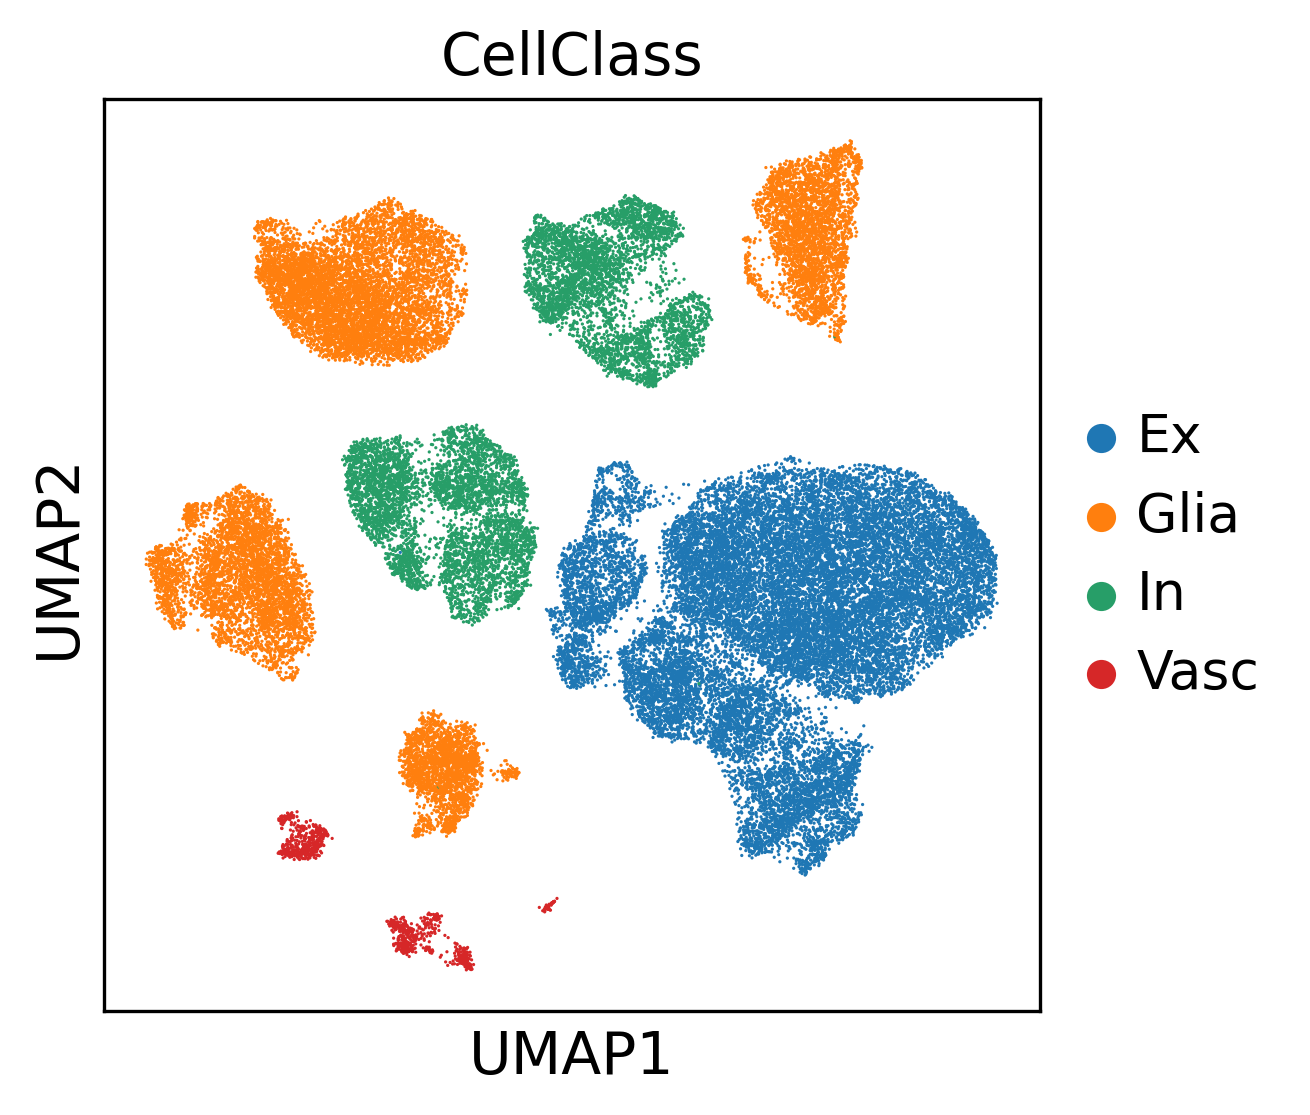

In [8]:
sc.pl.umap(adata, color="CellClass")

In [13]:
# Convert var index to str to avoid h5py error and write to disk
adata.var.index = adata.var.index.astype(str)
adata.write("../data/adata_unperturbed_geneformer.h5ad", compression="gzip")

## Perturb ALS genes and embed with Geneformer

Using the three first discovered definitive ALS genes from https://alsod.ac.uk/:

SOD1 - ENSG00000142168

VAPB - ENSG00000124164

TARDBP - ENSG00000120948

In [23]:
# Sanity check that all genes are in the dataset
adata.var.index = adata.var["ensembl_id"]
adata[:, ["ENSG00000142168", "ENSG00000124164", "ENSG00000120948"]].var

,Gene,Chromosome,Biotype,ensembl_id,gene_ids_collapsed
ensembl_id,,,,,
ENSG00000142168,SOD1,21,protein_coding,ENSG00000142168,ENSG00000142168
ENSG00000124164,VAPB,20,protein_coding,ENSG00000124164,ENSG00000124164
ENSG00000120948,TARDBP,1,protein_coding,ENSG00000120948,ENSG00000120948


### Knock-up simulation

In [24]:
# Perturbing all three genes at once by a factor of 2 in diseased cells
adata_ALS_perturb_3_up = perturb_genes(adata[adata.obs["Condition"]=="ALS"], ["ENSG00000142168", "ENSG00000124164", "ENSG00000120948"], [2., 2., 2.], copy=True)
adata_ALS_perturb_3_up.write("../data/adata_ALS_perturb_3_up.h5ad", compression="gzip")

In [25]:
# Embedding the perturbation dataset
get_embedding(adata_ALS_perturb_3_up)

INFO:helical.models.geneformer.model:Model finished initializing.
INFO:helical.models.geneformer.model:'gf-12L-95M-i4096' model is in 'eval' mode, on device 'cuda' with embedding mode 'cell'.
INFO:helical.models.geneformer.model:Processing data for Geneformer.
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [01:34<00:00,  1.69s/it]
  getattr(self, attr).index = value

  utils.warn_names_duplicates("var")

INFO:helical.models.geneformer.geneformer_tokenizer:AnnData object with n_obs × n_vars = 28500 × 36503
    obs: 'Sample_ID', 'Donor', 'Region', 'Sex', 'Condition', 'Group', 'C9_pos', 'CellClass', 'CellType', 'SubType', 'full_label', 'DGE_Group', 'Bakken_M1', 'total_counts'
    var: 'Gene', 'Chromosome', 'Biotype', 'ensembl_id', 'gene_ids_collapsed'
    uns: 'neighbors', 'umap', 'CellClass_colors'
    obsm: 'X_geneformer', 'X_umap'
    obsp: 'distances', 'con

... storing 'gene_ids_collapsed' as categorical


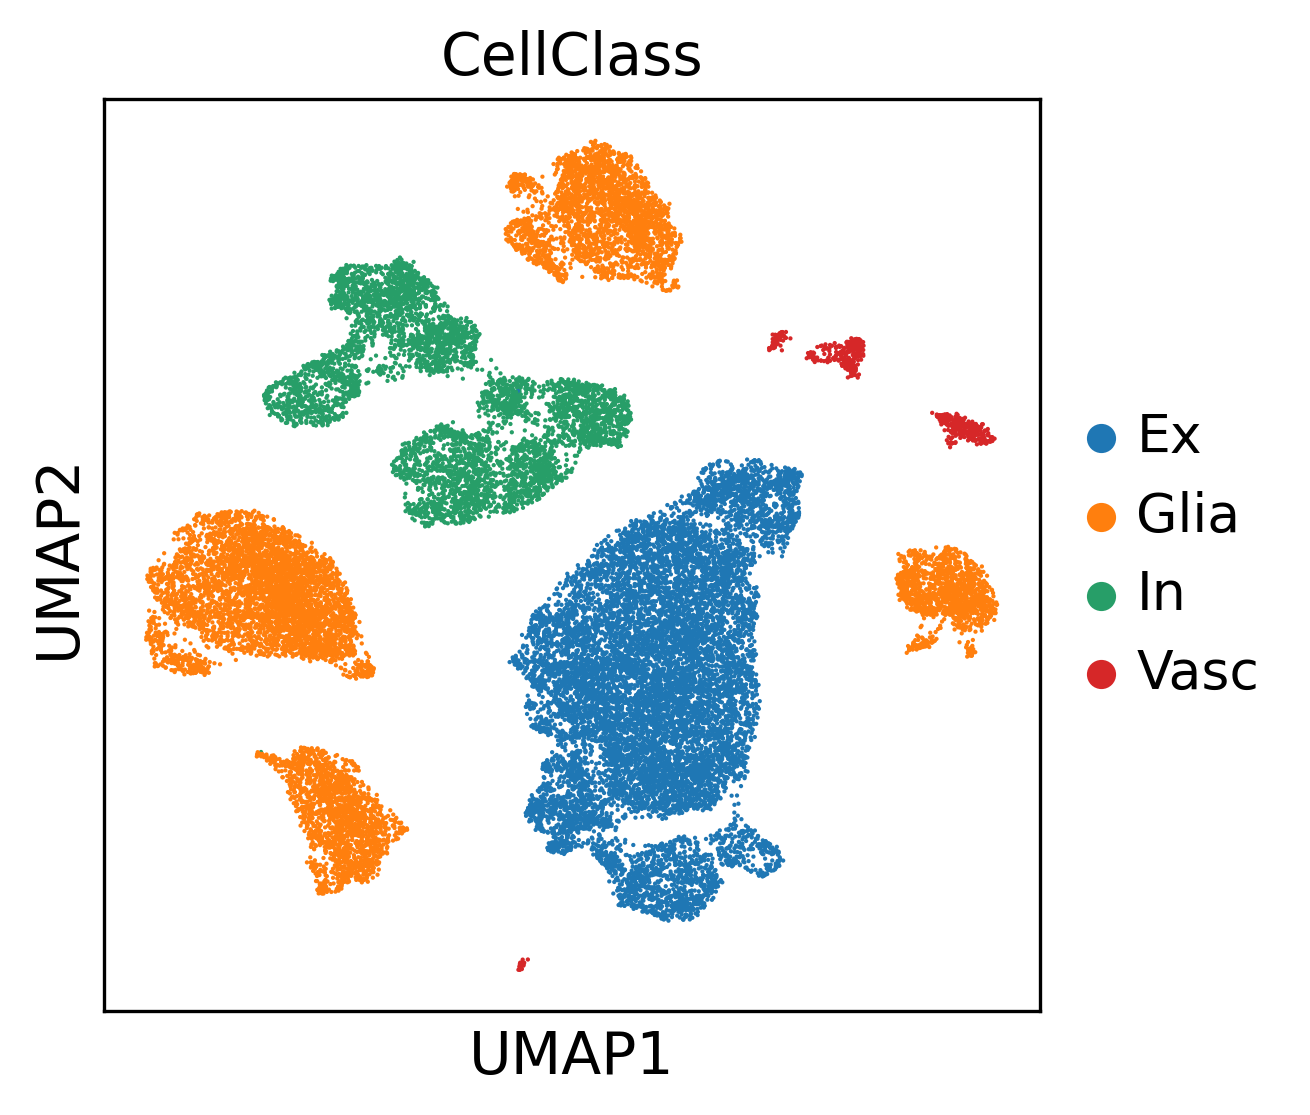

In [26]:
sc.pl.umap(adata_ALS_perturb_3_up, color="CellClass")

In [28]:
# Convert var index to str to avoid h5py error and write to disk
adata_ALS_perturb_3_up.var.index = adata_ALS_perturb_3_up.var.index.astype(str)
adata_ALS_perturb_3_up.write("../data/adata_ALS_perturb_3_up_geneformer.h5ad", compression="gzip")

### Knock-down simulation

In [30]:
# Perturbing all three genes at once by a factor of 0.5 in diseased cells
adata_ALS_perturb_3_down = perturb_genes(adata[adata.obs["Condition"]=="ALS"], ["ENSG00000142168", "ENSG00000124164", "ENSG00000120948"], [0.5, 0.5, 0.5], copy=True)
adata_ALS_perturb_3_down.write("../data/adata_ALS_perturb_3_down.h5ad", compression="gzip")

In [31]:
# Embedding the perturbation dataset
get_embedding(adata_ALS_perturb_3_down)

INFO:helical.models.geneformer.model:Model finished initializing.
INFO:helical.models.geneformer.model:'gf-12L-95M-i4096' model is in 'eval' mode, on device 'cuda' with embedding mode 'cell'.
INFO:helical.models.geneformer.model:Processing data for Geneformer.
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 56/56 [01:36<00:00,  1.71s/it]
  getattr(self, attr).index = value

  utils.warn_names_duplicates("var")

INFO:helical.models.geneformer.geneformer_tokenizer:AnnData object with n_obs × n_vars = 28500 × 36503
    obs: 'Sample_ID', 'Donor', 'Region', 'Sex', 'Condition', 'Group', 'C9_pos', 'CellClass', 'CellType', 'SubType', 'full_label', 'DGE_Group', 'Bakken_M1', 'total_counts'
    var: 'Gene', 'Chromosome', 'Biotype', 'ensembl_id', 'gene_ids_collapsed'
    uns: 'neighbors', 'umap', 'CellClass_colors'
    obsm: 'X_geneformer', 'X_umap'
    obsp: 'distances', 'con

... storing 'gene_ids_collapsed' as categorical


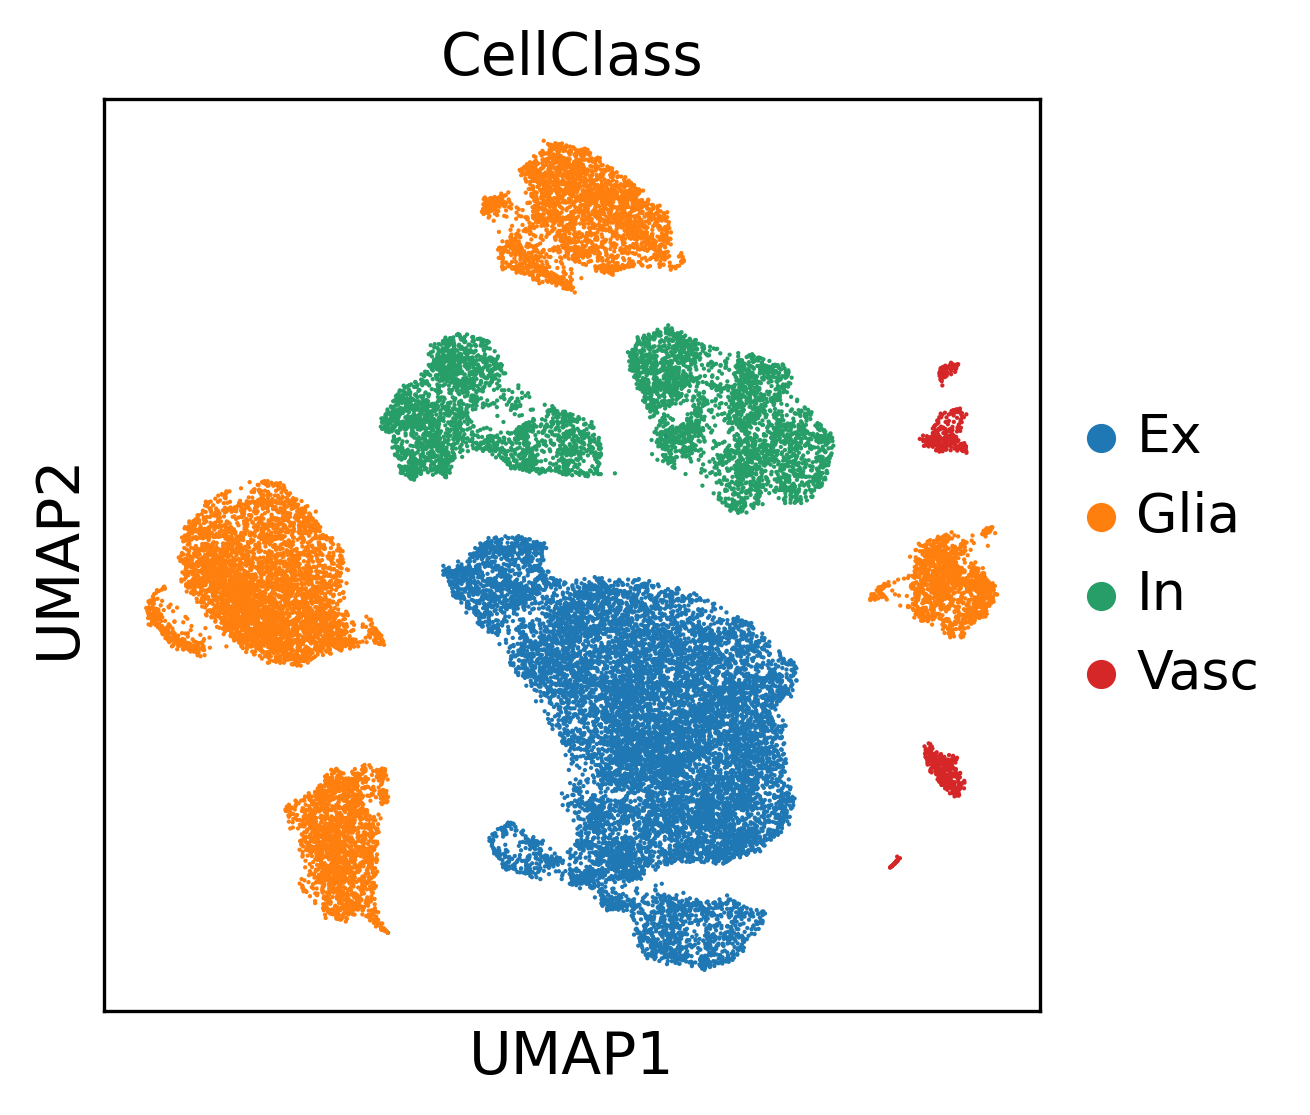

In [32]:
sc.pl.umap(adata_ALS_perturb_3_down, color="CellClass")

In [33]:
# Convert var index to str to avoid h5py error and write to disk
adata_ALS_perturb_3_down.var.index = adata_ALS_perturb_3_down.var.index.astype(str)
adata_ALS_perturb_3_down.write("../data/adata_ALS_perturb_3_down_geneformer.h5ad", compression="gzip")